# introduction to the vectorizing principle

## part 3: a slighly more complex example

#### load the data:

In [1]:
import pandas as pd
data_df = pd.read_csv('data/taxi_data/train.csv.gz')
len(data_df)

1458644

#### define (vectorized) functions for computing features:

In [2]:
import numpy as np
def feature_trip_distance(df: pd.DataFrame) -> pd.DataFrame:
    start_lat = np.radians(df["pickup_latitude"])
    start_lng = np.radians(df["pickup_longitude"])
    dest_lat = np.radians(df["dropoff_latitude"])
    dest_lng = np.radians(df["dropoff_longitude"])

    d = (
        np.sin(dest_lat / 2 - start_lat / 2) ** 2
        + np.cos(start_lat)
        * np.cos(dest_lat)
        * np.sin(dest_lng / 2 - start_lng / 2) ** 2
    )

    return pd.DataFrame(
        dict(
            # 6,371 km is the earth radius
            haversine_distance = 2 * 6371 * np.arcsin(np.sqrt(d))
        )
    )

def feature_split_pickup_datetime(df: pd.DataFrame) -> pd.DataFrame:
    tpep_pickup_datetime = pd.to_datetime(df["pickup_datetime"])

    return pd.DataFrame(
        {
            "pickup_dayofweek": tpep_pickup_datetime.dt.dayofweek,
            "pickup_hour": tpep_pickup_datetime.dt.hour,
            "pickup_minute": tpep_pickup_datetime.dt.minute,
        }
    )

def get_feature_df(df: pd.DataFrame, target_col="trip_duration") -> pd.DataFrame:
    return pd.concat(
        [
            df[[col for col in df.columns if col != target_col and df[col].dtype in (int, float, bool)]],
            feature_trip_distance(df),
            feature_split_pickup_datetime(df),
        ],
        axis="columns",
    ), df[target_col]


#### split the data into train and test:

In [3]:
from sklearn.model_selection import train_test_split
features_df, target_series = get_feature_df(data_df)
(
    features_train,
    features_test,
    target_train,
    target_test,
) = train_test_split(features_df, target_series, test_size=0.1)

#### train a simple model:

In [4]:
import lightgbm
model = lightgbm.LGBMRegressor(objective="regression_l1")
model.fit(features_train, target_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 1312779, number of used features: 10
[LightGBM] [Info] Start training from score 663.000000


LGBMRegressor(objective='regression_l1')

#### evaluate the model:

0.03274949828738205
3057.0113543999473


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

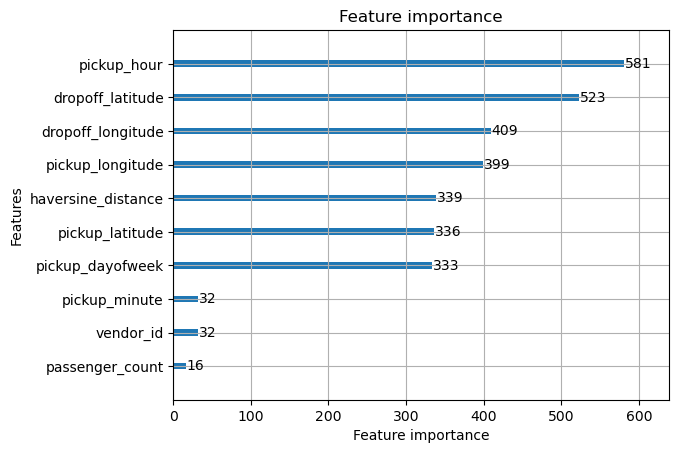

In [5]:
from sklearn.metrics import mean_squared_error
import math
predicted = model.predict(features_test)
print(model.score(features_test, target_test))
print(math.sqrt(mean_squared_error(target_test, predicted)))
lightgbm.plot_importance(model)